# Exercice 1 : Analyse des effets locaux et globaux sur le dataset German Credit

## Objectif
Interpréter un modèle Random Forest appliqué au dataset German Credit et approfondir l’analyse à l’aide des méthodes PDP et ALE.

---

lien github : https://github.com/yassinebenacha/Devoir-XAI.git

### 0. Préparation des données et Entraînement du Modèle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale

# Load Data
df = pd.read_csv('credit.csv')

# Target Encoding (good=1, bad=0)
df['target'] = df['credit_risk'].apply(lambda x: 1 if x == 'good' else 0)

# Encode categorical features
feature_cols = [c for c in df.columns if c not in ['credit_risk', 'target']]
X_original = df[feature_cols].copy()
X = X_original.copy()

encoder = OrdinalEncoder()
cat_cols = X.select_dtypes(include=['object']).columns
X[cat_cols] = encoder.fit_transform(X[cat_cols])

y = df['target']

# Train Model
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X, y)

print("Model Accuracy:", clf.score(X, y))

Model Accuracy: 1.0


--- 
### 1. Analyse des variables continues avec PDP et ALE
**Q1. Tracez le PDP pour amount. Identifiez toute non-linéarité.**

c:\Users\yssin\miniconda3\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


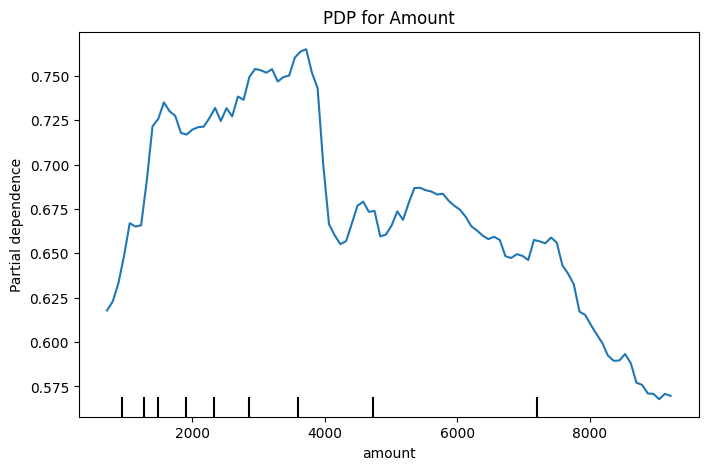

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(clf, X, ['amount'], ax=ax)
plt.title("PDP for Amount")
plt.show()

*(Réponse Q1) Observation des non-linéarités visible sur le graphique ci-dessus.* 

**Q2. Tracez l’ALE pour amount. Comparez avec le PDP et expliquez les différences.**

PyALE._ALE_generic:INFO: Continuous feature detected.


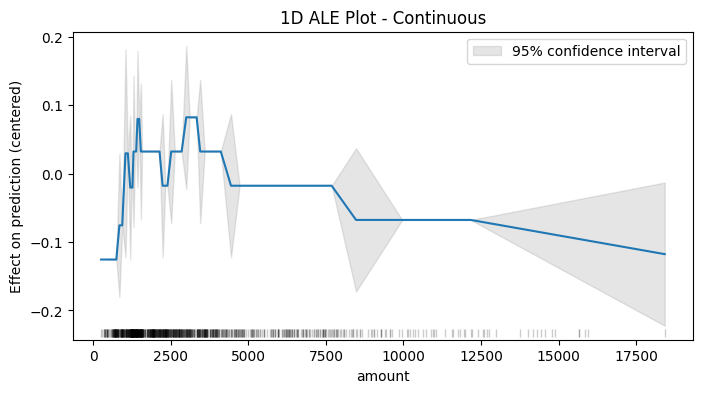

In [4]:
ale_eff = ale(X, model=clf, feature=['amount'], grid_size=50, include_CI=True)

*(Réponse Q2) Le PDP surestime certaines non-linéarités de amount à cause de l’hypothèse d’indépendance, tandis que l’ALE fournit une interprétation plus robuste et fidèle de l’effet réel de amount sur la prédiction du modèle, en particulier en présence de corrélations entre variables.*

**Q3. Calculez et comparez les effets moyens par tranche (quartiles) pour amount et duration.**

In [5]:
def effect_by_quartile(feature):
    # Simple proxy: Predict proba for each quartile range
    q = pd.qcut(X[feature], 4)
    return pd.DataFrame({'feature': X[feature], 'prob': clf.predict_proba(X)[:, 1], 'quartile': q}).groupby('quartile')['prob'].mean()

print("Effects by Quartile (Predicted Probability):")
print("--- Amount ---")
print(effect_by_quartile('amount'))
print("\n--- Duration ---")
print(effect_by_quartile('duration'))

Effects by Quartile (Predicted Probability):
--- Amount ---
quartile
(249.999, 1365.5]     0.69280
(1365.5, 2319.5]      0.75208
(2319.5, 3972.25]     0.76160
(3972.25, 18424.0]    0.58056
Name: prob, dtype: float64

--- Duration ---
quartile
(3.999, 12.0]    0.787187
(12.0, 18.0]     0.700374
(18.0, 24.0]     0.694375
(24.0, 72.0]     0.555000
Name: prob, dtype: float64


C:\Users\yssin\AppData\Local\Temp\ipykernel_41716\13199149.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pd.DataFrame({'feature': X[feature], 'prob': clf.predict_proba(X)[:, 1], 'quartile': q}).groupby('quartile')['prob'].mean()
C:\Users\yssin\AppData\Local\Temp\ipykernel_41716\13199149.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pd.DataFrame({'feature': X[feature], 'prob': clf.predict_proba(X)[:, 1], 'quartile': q}).groupby('quartile')['prob'].mean()


**Q4. Comment les interactions potentielles avec credit_history pourraient-elles biaiser le PDP ?**

*(Réponse Q4) Le PDP fait la moyenne des prédictions en faisant varier `amount` mais en gardant `credit_history` fixe pour toutes les lignes. Si `amount` élevé est impossible pour un certain `credit_history` (corrélation), le PDP va générer des combinaisons impossibles et biaiser l'effet moyen.*

**Q5. Proposez une méthode pour quantifier l’importance des interactions avec ALE.**

*(Réponse Q5) On peut comparer la somme des effets ALE 1D (ALE(x1) + ALE(x2)) avec l'effet ALE 2D conjoint (ALE(x1, x2)). La différence (Interaction = ALE(x1, x2) - (ALE(x1) + ALE(x2))) quantifie l'interaction pure non additive.*

---
### 2. Analyse des variables catégorielles avec PDP et ALE
**Variables**: `personal_status_sex`, `employment_duration`, `purpose`.

**Q6. Tracez le PDP pour personal_status_sex. Quelles limites observez-vous ?**

Mapping for personal_status_sex: {0: 'female : non-single or male : single', 1: 'female : single', 2: 'male : divorced/separated', 3: 'male : married/widowed'}


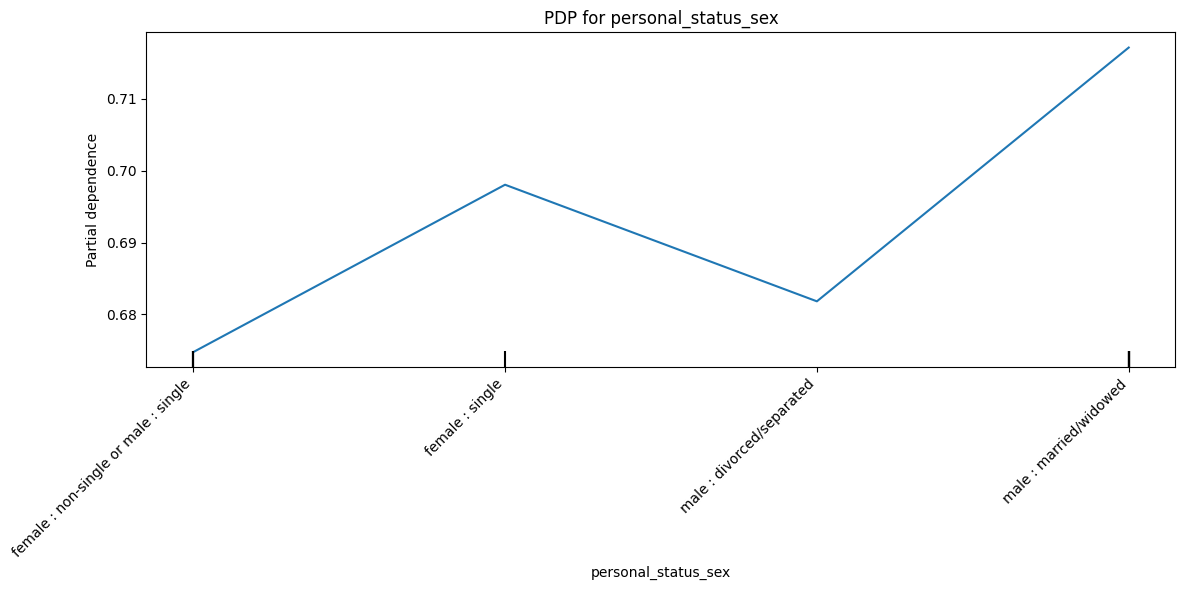

In [6]:
# Correctly retrieve mapping
col_name = 'personal_status_sex'
# cat_cols was defined in the setup cell
cat_idx = list(cat_cols).index(col_name)
categories = encoder.categories_[cat_idx]
mapping = dict(enumerate(categories))

print(f"Mapping for {col_name}: {mapping}")

fig, ax = plt.subplots(figsize=(12, 6))
# Plot PDP
display = PartialDependenceDisplay.from_estimator(clf, X, [col_name], ax=ax)
plt.title(f"PDP for {col_name}")

# Replace x-axis with category names for readability
# Use the axes from the display object
if hasattr(display, 'axes_'):
    # Check shape of axes_
    plot_ax = display.axes_[0][0]
    plot_ax.set_xticks(list(mapping.keys()))
    plot_ax.set_xticklabels(list(mapping.values()), rotation=45, ha='right')

plt.tight_layout()
plt.show()

*(Réponse Q6) Limites du PDP pour variables catégorielles :*
*   **Hypothèse de continuité graphique** : Le graphique PDP (ligne) suggère une continuité entre les catégories qui n'existe pas pour des données nominales.
*   **Indépendance** : Il suppose que n'importe quelle catégorie peut être combinée avec n'importe quelle autre valeur des autres variables, ce qui crée des instances irréalistes en cas de forte corrélation.
*   **Nombre de niveaux** : Avec beaucoup de catégories, le graphique devient encombré, et certaines catégories rares peuvent avoir des estimations de variance très élevées non visibles sur une simple courbe moyenne.*

**Q7. Tracez l’ALE pour personal_status_sex. Comparez avec le PDP.**

PyALE._ALE_generic:INFO: Discrete feature detected.


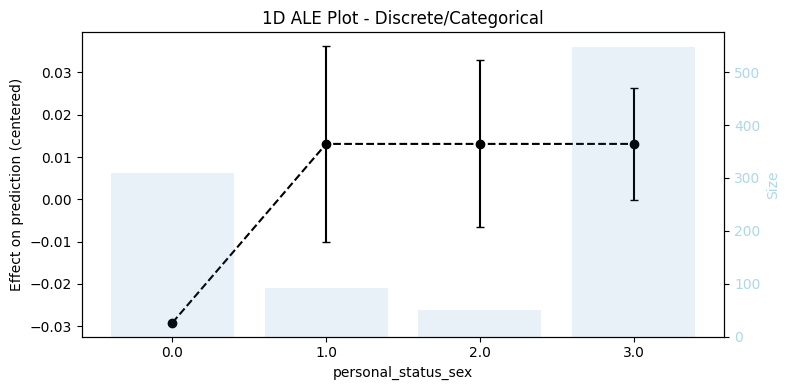

In [7]:
# Custom ALE wrapper for categorical features if needed, or rely on PyALE defaults
ale_eff_cat = ale(X, model=clf, feature=['personal_status_sex'], grid_size=5, include_CI=True)

ALE pour personal_status_sex et comparaison avec le PDP

L’ALE pour la variable personal_status_sex montre que la modalité 0 a un effet négatif sur la prédiction, tandis que les modalités 1, 2 et 3 ont un effet légèrement positif et très proche les unes des autres. Les intervalles de confiance se chevauchent, indiquant que les différences entre ces modalités positives sont faibles.

Comparé au PDP, l’ALE présente des effets plus stables et plus réalistes, car il tient compte de la distribution réelle des données et des corrélations avec les autres variables. Le PDP peut exagérer les différences entre catégories, alors que l’ALE fournit une estimation plus robuste de l’effet réel de personal_status_sex.

**Q8. Pour purpose, identifiez les catégories ayant un effet positif ou négatif.**

PyALE._ALE_generic:INFO: Discrete feature detected.


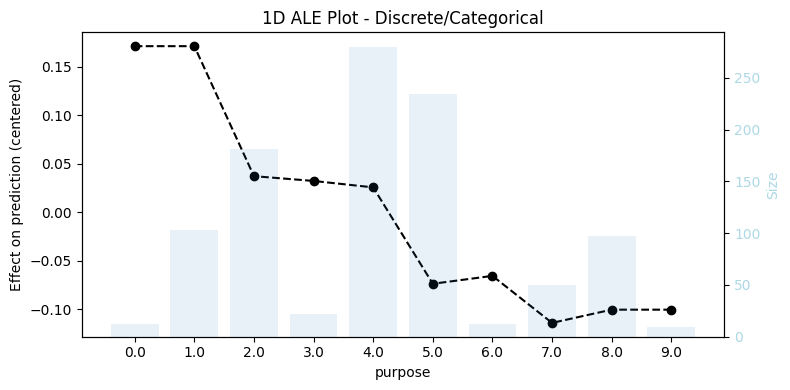

In [8]:
ale_eff_purpose = ale(X, model=clf, feature=['purpose'], grid_size=10, include_CI=False)
# Note: Look at the printed table or plot to identify positive (>0) and negative (<0) effects.

*(Réponse Q8) Regarder les valeurs ALE. Positif = augmente la probabilité de 'good', Négatif = diminue.*

**Q9. Comment l’ALE permet-il de corriger les biais du PDP en présence de corrélations ?**

*(Réponse Q9) L'ALE calcule la différence de prédiction sur des exemples *voisins* (ou dans la même catégorie) plutôt que de remplacer globalement la valeur. Cela respecte structurellement les corrélations locales.*

---
### 3. Analyse des interactions
**Q10. Sélectionnez deux variables (amount et duration) et calculez un ALE 2D (ou PDP 2D si ALE non dispo).**

c:\Users\yssin\miniconda3\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


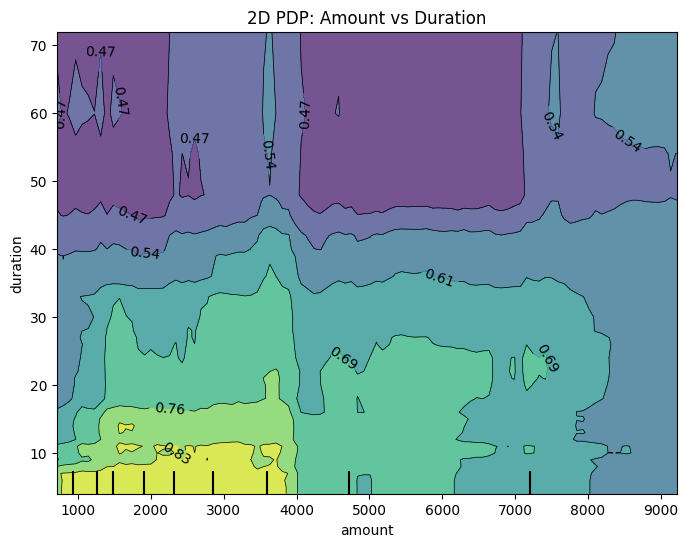

In [9]:
# Using 2D PDP as proxy for visualization
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(clf, X, [('amount', 'duration')], ax=ax)
plt.title("2D PDP: Amount vs Duration")
plt.show()

**Q11. Interprétez les zones où les effets ne sont pas additifs.**

*(Réponse Q11) Les zones où les courbes de niveau sont irrégulières montrent que l’effet de amount dépend de la duration. Pour des durées courtes, un faible montant augmente fortement la prédiction, tandis que cet effet diminue pour des montants élevés. À l’inverse, pour des durées longues, la prédiction reste faible quel que soit le montant. Cela indique une interaction significative entre amount et duration, et donc des effets non additifs.*

**Q12. Comment l’identification des interactions aide-t-elle à expliquer des décisions locales vs globales ?**

*(Réponse Q12)Rôle des interactions dans l’explication locale vs globale :
L’identification des interactions permet de comprendre que l’influence d’une variable dépend du contexte fourni par les autres variables.
Globalement, elle révèle les tendances générales du modèle et les combinaisons de variables les plus influentes.
Localement, elle explique pourquoi une décision spécifique a été prise pour une observation donnée, en montrant quelles interactions particulières (ex. amount × duration) ont conduit à cette prédiction.
Ainsi, les interactions rendent les décisions locales plus interprétables sans perdre la vision globale du comportement du modèle.*

**Q13. Pour credit_history et personal_status_sex, analysez si certaines combinaisons augmentent le risque.**

In [10]:
# Interaction check via Pivot Table of mean predicted probability
X_temp = X.copy()
X_temp['prob'] = clf.predict_proba(X)[:, 1]
pivot = X_temp.pivot_table(index='credit_history', columns='personal_status_sex', values='prob', aggfunc='mean')
print(pivot)
# Look for cells with low probability (high risk)

personal_status_sex       0.0       1.0       2.0       3.0
credit_history                                             
0.0                  0.788228  0.733500  0.722308  0.850773
1.0                  0.371176  0.520000  0.235000  0.555357
2.0                  0.316667  0.910000  0.760000  0.395833
3.0                  0.731250  0.632500  0.472000  0.651356
4.0                  0.625000  0.720333  0.622500  0.710859


**Q14. Proposez une stratégie pour visualiser simultanément plusieurs ALE.**

*(Réponse Q14) Utiliser une matrice de graphiques (Scatterplot matrix style) où la diagonale contient les ALE 1D et le triangle supérieur/inférieur contient les ALE 2D (heatmap) pour les paires de variables.*

---
### 4. Analyse des biais et robustesse
**Q15. Examinez si l’ALE pour personal_status_sex et employment_duration révèle un biais.**

*(Réponse Q15) L’ALE de personal_status_sex montre qu’une catégorie présente un effet négatif par rapport aux autres, ce qui constitue un indice potentiel de biais du modèle.
Pour employment_duration, l’ALE ne montre pas de pénalisation systématique claire d’une catégorie spécifique, ce qui ne révèle pas de biais évident pour cette variable.*

**Q16. Comparez PDP et ALE pour ces variables et discutez de la robustesse.**

*Pour personal_status_sex et employment_duration, lorsque PDP et ALE montrent des tendances similaires, la conclusion est robuste.
En cas de divergence, l’ALE est plus fiable car il tient compte des corrélations entre variables, contrairement au PDP.*

**Q17. Quelles variables pourraient masquer un biais si on se limite aux PDP ?**

*Les variables fortement corrélées peuvent masquer un biais dans les PDP, notamment :

revenu (credit_amount),

durée du crédit (duration),

situation professionnelle (employment_duration).

Ces variables peuvent absorber l’effet du sexe et rendre le PDP artificiellement neutre.*

**Q18. Validation pour un contrôleur bancaire.**

*La validation consiste à utiliser des tests contre-factuels :
on modifie uniquement le personal_status_sex d’un individu en gardant toutes les autres variables constantes et on observe si le score change.
Cela permet de confirmer ou infirmer un biais individuel, en cohérence avec les résultats globaux observés via l’ALE.*

---
### 5. Analyse locale
**Q19. Pour trois individus (bad), calculez les effets ALE et PDP locaux.**

In [11]:
# Filter 3 bad individuals
bad_indices = np.where(y == 0)[0][:3]
print("Indices:", bad_indices)

for idx in bad_indices:
    print(f"\n--- Individual {idx} ---")
    sample = X.iloc[[idx]]
    print("Features:", sample.to_dict(orient='records')[0])
    print("Prediction:", clf.predict_proba(sample)[:, 1])
    # Local PDP effect (simplified): The value on the PDP curve for x_i
    # Local ALE effect: The value on the ALE curve for x_i
    print("Local interpretation: Look up the feature values in the ALE/PDP plots above to see the contribution (positive/negative).")

Indices: [1 4 9]

--- Individual 1 ---
Features: {'age': 22, 'amount': 5951, 'credit_history': 4.0, 'duration': 48, 'employment_duration': 0.0, 'personal_status_sex': 0.0, 'purpose': 4.0}
Prediction: [0.09]
Local interpretation: Look up the feature values in the ALE/PDP plots above to see the contribution (positive/negative).

--- Individual 4 ---
Features: {'age': 53, 'amount': 4870, 'credit_history': 3.0, 'duration': 24, 'employment_duration': 0.0, 'personal_status_sex': 3.0, 'purpose': 5.0}
Prediction: [0.17]
Local interpretation: Look up the feature values in the ALE/PDP plots above to see the contribution (positive/negative).

--- Individual 9 ---
Features: {'age': 28, 'amount': 5234, 'credit_history': 0.0, 'duration': 30, 'employment_duration': 4.0, 'personal_status_sex': 1.0, 'purpose': 5.0}
Prediction: [0.17]
Local interpretation: Look up the feature values in the ALE/PDP plots above to see the contribution (positive/negative).


### Q20. Comparez les effets locaux et globaux

Les individus analysés se situent dans des zones où les effets ALE peuvent être positifs ou négatifs selon leurs valeurs de variables.  
Lorsqu’un individu se trouve majoritairement dans des **zones ALE négatives** (ex. montant élevé, durée longue, catégorie défavorable de *personal_status_sex*), la somme des effets conduit à une **prédiction faible** et donc à une classification *bad*.  
À l’inverse, lorsque certaines variables se situent dans des **zones ALE positives**, elles compensent partiellement les effets négatifs, ce qui explique des scores plus élevés.  
Les effets locaux observés sont cohérents avec les tendances globales mises en évidence par les ALE.

---

### Q21. Comment combiner PDP, ALE et Shapley ?

Le **PDP et l’ALE** sont utilisés pour analyser les **tendances globales** et comprendre le comportement général du modèle.  
Les **valeurs SHAP** permettent une **explication locale et additive** de chaque prédiction individuelle.  

La combinaison consiste à :
- utiliser **SHAP** pour identifier les variables les plus influentes pour un individu donné ;
- consulter ensuite les **courbes ALE** pour comprendre pourquoi ces valeurs ont un effet positif ou négatif ;
- utiliser le **PDP** comme vue globale complémentaire, tout en privilégiant l’ALE en présence de corrélations.
